# **Mount drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# **Import important libraries**

In [2]:
import numpy as np
import cv2
import pywt
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# **Problem 0) Panorama Stitching**

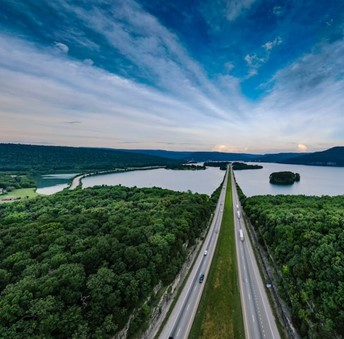

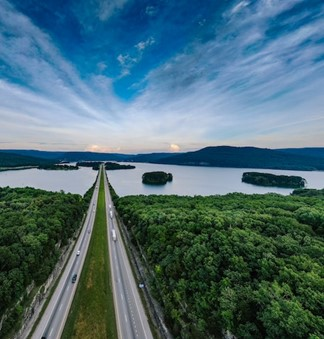

In [ ]:
# Load images
img1 = cv2.imread('/content/drive/MyDrive/EE608/HW_4_data/pana_1.jpg')
img2 = cv2.imread('/content/drive/MyDrive/EE608/HW_4_data/pana_2.jpg')

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

cv2_imshow(img1)
cv2_imshow(img2)

In [ ]:
# detect keypoints and extract features using SIFT
sift = cv2.xfeatures2d.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

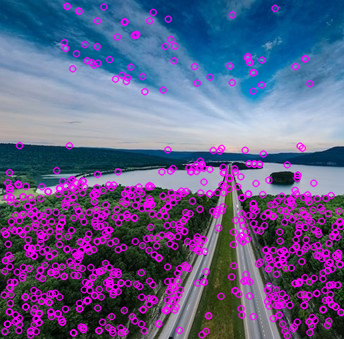

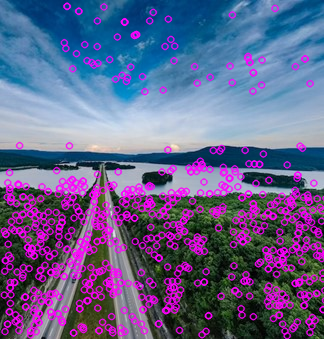

In [ ]:
cv2_imshow(cv2.drawKeypoints(img1, keypoints1, None, (255, 0, 255)))
cv2_imshow(cv2.drawKeypoints(img2, keypoints1, None, (255, 0, 255)))

In [ ]:
bf = cv2.BFMatcher(cv2.NORM_L1,crossCheck=False)
matches = bf.knnMatch(descriptors1, descriptors2,k=2)

In [ ]:
print(keypoints1[0].pt)
print(keypoints1[0].size)

(3.735511302947998, 230.56170654296875)
2.730574131011963


In [ ]:
print("Descriptor of the first keypoint: ")
print(descriptors1[0])

Descriptor of the first keypoint: 
[ 13.   0.   6.  30.  22.  16.   2.   2.  52.   0.   0.   0.   2.   1.
   0.   7.   3.   0.   0.   1.   4.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  69.   2.   3.  10.  56. 135.  25.  26. 135.  18.
   0.   5.  38.  25.   2.  20.  41.   3.   1.  23. 135.  26.   7.  11.
  24.   8.  23.  13.   9.   5.   5.  15.  58.   9.  27.   7.  58. 115.
  14.  36. 135.   9.   3.  20.  59.  57.  19.  80.  29.   9.  15.  87.
 135.  40.   9.   9.  39.  23.  43.  66.  29.   6.   5.  13.  29.  69.
  87.  30.  17.   9.   4.   7. 135.  48.  11.   3.  31.  40.   7.  33.
  18.   2.   4.  23. 135. 135.   2.   5.  99.  17.   5.  29.  67.  20.
   0.   9.]


In [ ]:
def draw_matches(img1, keypoints1, img2, keypoints2, matches):
  r, c = img1.shape[:2]
  r1, c1 = img2.shape[:2]

  # Create a blank image with the size of the first image + second image
  output_img = np.zeros((max([r, r1]), c+c1, 3), dtype='uint8')
  output_img[:r, :c, :] = np.dstack([img1, img1, img1])
  output_img[:r1, c:c+c1, :] = np.dstack([img2, img2, img2])

  # Go over all of the matching points and extract them
  for match in matches:
    img1_idx = match.queryIdx
    img2_idx = match.trainIdx
    (x1, y1) = keypoints1[img1_idx].pt
    (x2, y2) = keypoints2[img2_idx].pt

    # Draw circles on the keypoints
    cv2.circle(output_img, (int(x1),int(y1)), 4, (0, 255, 255), 1)
    cv2.circle(output_img, (int(x2)+c,int(y2)), 4, (0, 255, 255), 1)

    # Connect the same keypoints
    cv2.line(output_img, (int(x1),int(y1)), (int(x2)+c,int(y2)), (0, 255, 255), 1)
    
  return output_img

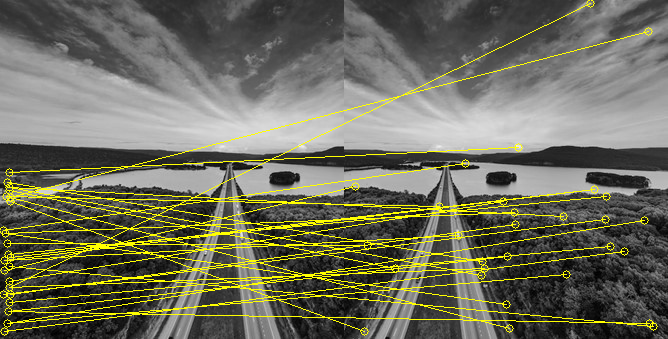

In [ ]:
all_matches = []
for m, n in matches:
  all_matches.append(m)

img3 = draw_matches(img1_gray, keypoints1, img2_gray, keypoints2, all_matches[:30])
cv2_imshow(img3)

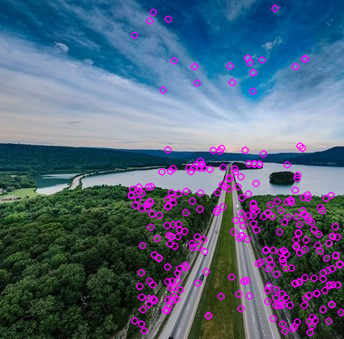

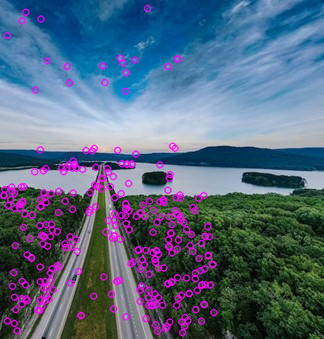

In [ ]:
# Finding the best matches
good = []
for m, n in matches:
    if m.distance < 0.6 * n.distance:
        good.append(m)
cv2_imshow(cv2.drawKeypoints(img1, [keypoints1[m.queryIdx] for m in good], None, (255, 0, 255)))
cv2_imshow(cv2.drawKeypoints(img2, [keypoints2[m.trainIdx] for m in good], None, (255, 0, 255)))

In [ ]:
def warpImages(img1, img2, H):

  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]

  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

  # When we have established a homography we need to warp perspective
  # Change field of view
  list_of_points_2 = cv2.perspectiveTransform(temp_points, H)

  list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  
  translation_dist = [-x_min,-y_min]
  
  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

  output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1
  return output_img

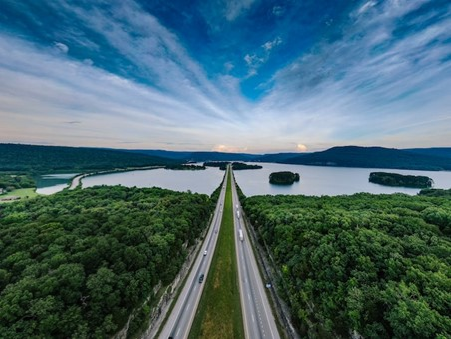

In [ ]:
# Set minimum match condition
MIN_MATCH_COUNT = 10

if len(good) > MIN_MATCH_COUNT:
    # Convert keypoints to an argument for findHomography
    src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

    # Establish a homography
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    
    result = warpImages(img2, img1, M)

    cv2_imshow(result)

# **Problem 1) Motion Estimation**

In [ ]:
# read the first two frames of the video
cap = cv2.VideoCapture('/content/drive/MyDrive/EE608/HW_4_data/ocean.mp4')
ret, frame1 = cap.read()
ret, frame2 = cap.read()

# convert the frames to grayscale
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

# convert the frames to numpy arrays
frame1 = np.array(frame1)
frame2 = np.array(frame2)

# release the video capture object
cap.release()

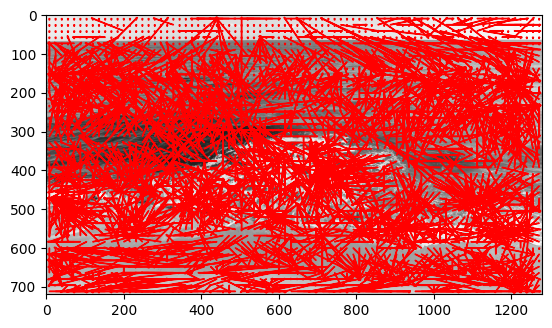

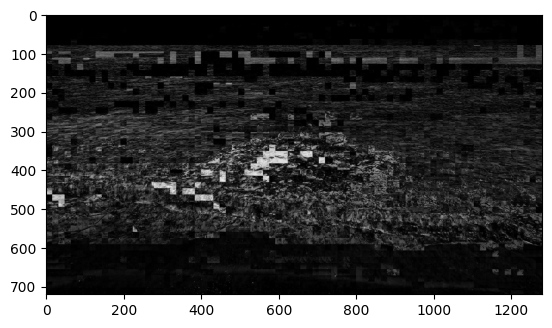

In [ ]:
# define macroblock size and search range
MB_SIZE = 16
SEARCH_RANGE = 4

# get the dimensions of the frames
height, width = frame1.shape

# divide each frame into non-overlapping macroblocks
mb_height = height // MB_SIZE
mb_width = width // MB_SIZE

# initialize motion vectors and error array
motion_vectors = np.zeros((mb_height, mb_width, 2), dtype=int)
errors = np.zeros((mb_height, mb_width))

# loop over all macroblocks in the second frame
for mb_y in range(mb_height):
    for mb_x in range(mb_width):
        
        # get the current macroblock in the second frame
        mb2 = frame2[mb_y*MB_SIZE : (mb_y+1)*MB_SIZE, mb_x*MB_SIZE : (mb_x+1)*MB_SIZE]
        
        # initialize best match and error for step 1
        best_match = (0, 0)
        min_error = np.inf
        
        # search at 8 locations around the current macroblock in step 1
        for dy in range(-SEARCH_RANGE, SEARCH_RANGE+1, SEARCH_RANGE):
            for dx in range(-SEARCH_RANGE, SEARCH_RANGE+1, SEARCH_RANGE):
                if mb_y+dy >= 0 and mb_y+dy < mb_height and mb_x+dx >= 0 and mb_x+dx < mb_width:
                    
                    # get the macroblock in the first frame at the current location
                    mb1 = frame1[(mb_y+dy)*MB_SIZE : (mb_y+dy+1)*MB_SIZE, (mb_x+dx)*MB_SIZE : (mb_x+dx+1)*MB_SIZE]
                    
                    # compute the mean absolute distance (MAD) between the two macroblocks
                    error = np.abs(mb1 - mb2).mean()
                    
                    # update best match and error if a better match is found
                    if error < min_error:
                        best_match = (dx, dy)
                        min_error = error
        
        # perform step 2 search around the best match location in step 1
        for dy in range(-SEARCH_RANGE//2, SEARCH_RANGE//2+1):
            for dx in range(-SEARCH_RANGE//2, SEARCH_RANGE//2+1):
                x = mb_x + best_match[0] + dx
                y = mb_y + best_match[1] + dy
                if x >= 0 and x < mb_width and y >= 0 and y < mb_height:
                    mb1 = frame1[y*MB_SIZE : (y+1)*MB_SIZE, x*MB_SIZE : (x+1)*MB_SIZE]
                    error = np.abs(mb1 - mb2).mean()
                    if error < min_error:
                        best_match = (x-mb_x, y-mb_y)
                        min_error = error
        
        # perform step 3 search around the best match location in step 2
        for dy in range(-1, 2):
            for dx in range(-1, 2):
                x = mb_x + best_match[0] + dx
                y = mb_y + best_match[1] + dy
                if x >= 0 and x < mb_width and y >= 0 and y < mb_height:
                    mb1 = frame1[y*MB_SIZE : (y+1)*MB_SIZE, x*MB_SIZE : (x+1)*MB_SIZE]
                    error = np.abs(mb1 - mb2).mean()
                    if error < min_error:
                        best_match = (x-mb_x, y-mb_y)
                        min_error = error

        # save the motion vector and error for the current macroblock
        motion_vectors[mb_y, mb_x] = best_match
        errors[mb_y, mb_x] = min_error

# generate the motion-compensated predicted frame
predicted_frame = np.zeros((height, width))
for mb_y in range(mb_height):
    for mb_x in range(mb_width):
      # get the motion vector for the current macroblock
        dx, dy = motion_vectors[mb_y, mb_x]
        
        # get the macroblock in the first frame at the current location
        mb1 = frame1[(mb_y+dy)*MB_SIZE : (mb_y+dy+1)*MB_SIZE, (mb_x+dx)*MB_SIZE : (mb_x+dx+1)*MB_SIZE]
        
        # copy the macroblock from the first frame to the predicted frame
        predicted_frame[mb_y*MB_SIZE : (mb_y+1)*MB_SIZE, mb_x*MB_SIZE : (mb_x+1)*MB_SIZE] = mb1
# compute the error between the second frame and its motion-compensated predicted version
error_frame = np.abs(frame2 - predicted_frame)

# display the motion vectors as arrows
plt.imshow(frame2, cmap='gray')
for mb_y in range(mb_height):
    for mb_x in range(mb_width):
        dx, dy = motion_vectors[mb_y, mb_x]
        x = mb_x*MB_SIZE + MB_SIZE//2
        y = mb_y*MB_SIZE + MB_SIZE//2
        plt.arrow(x, y, dx*MB_SIZE, dy*MB_SIZE, width=1, color='r')
plt.show()

# display the error frame
plt.imshow(error_frame, cmap='gray')
plt.show()

# **Problem 2) Optical Flow**

# **Optical flow || FAST VIDEO**

In [ ]:
# Load the video
cap = cv2.VideoCapture('/content/drive/MyDrive/EE608/HW_4_data/car_moving_red_fast.mp4')

# Define the parameters for the Lucas-Kanade algorithm
lk_params = dict(winSize=(15, 15),
                 maxLevel=4,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Take the first frame and convert it to grayscale
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

# Detect features in the first frame using Shi-Tomasi corner detection
corners = cv2.goodFeaturesToTrack(old_gray, maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# Create an array of feature points to track
p0 = np.float32(corners)

# Create a mask for the features to track
mask = np.zeros_like(old_frame)

# Create a colormap for the optical flow visualization
color = np.random.randint(0, 255, (100, 3))

# Define a variable to store the optical flow magnitude for each frame
flow_magnitude = []

# Loop through all the frames of the video
while True:
    # Read the next frame and convert it to grayscale
    ret, frame = cap.read()
    if not ret:
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Compute the optical flow using the Lucas-Kanade algorithm
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Check if p1 is not None before accessing it
    if p1 is None:
        continue

    # Select good points
    good_new = p1[st == 1]
    good_old = p0[st == 1]

    # Compute the optical flow magnitude
    flow_mag = np.sqrt((good_new[:,0]-good_old[:,0])**2 + (good_new[:,1]-good_old[:,1])**2).mean()
    flow_magnitude.append(flow_mag)
    # Draw the optical flow tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        pt1 = (int(round(a)), int(round(b)))
        pt2 = (int(round(c)), int(round(d)))
        mask = cv2.line(mask, pt1, pt2, color[i % 100].tolist(), 2)
        frame = cv2.circle(frame, pt1, 5, color[i % 100].tolist(), -1)

    # Overlay the optical flow tracks on the original frame
    img = cv2.add(frame, mask)

    # Display the resulting frame
    cv2_imshow(img)

    # Exit on ESC key
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

    # Update the previous frame and feature points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

# Release the video and close all windows
cap.release()
cv2.destroyAllWindows()


Output hidden; open in https://colab.research.google.com to view.

# **Optical Flow || SLOW VIDEO**

In [ ]:
# Load the video
cap = cv2.VideoCapture('/content/drive/MyDrive/EE608/HW_4_data/car_moving_red_slow.mp4')

# Define the parameters for the Lucas-Kanade algorithm
lk_params = dict(winSize=(15, 15),
                 maxLevel=4,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Take the first frame and convert it to grayscale
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

# Detect features in the first frame using Shi-Tomasi corner detection
corners = cv2.goodFeaturesToTrack(old_gray, maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# Create an array of feature points to track
p0 = np.float32(corners)

# Create a mask for the features to track
mask = np.zeros_like(old_frame)

# Create a colormap for the optical flow visualization
color = np.random.randint(0, 255, (100, 3))

# Define a variable to store the optical flow magnitude for each frame
flow_magnitude_slow = []

# Loop through all the frames of the video
while True:
    # Read the next frame and convert it to grayscale
    ret, frame = cap.read()
    if not ret:
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Compute the optical flow using the Lucas-Kanade algorithm
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Check if p1 is not None before accessing it
    if p1 is None:
        continue

    # Select good points
    good_new = p1[st == 1]
    good_old = p0[st == 1]
    
    # Compute the optical flow magnitude
    flow_mag = np.sqrt((good_new[:,0]-good_old[:,0])**2 + (good_new[:,1]-good_old[:,1])**2).mean()
    flow_magnitude_slow.append(flow_mag)
    # Draw the optical flow tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        pt1 = (int(round(a)), int(round(b)))
        pt2 = (int(round(c)), int(round(d)))
        mask = cv2.line(mask, pt1, pt2, color[i % 100].tolist(), 2)
        frame = cv2.circle(frame, pt1, 5, color[i % 100].tolist(), -1)

    # Overlay the optical flow tracks on the original frame
    img = cv2.add(frame, mask)

    # Display the resulting frame
    cv2_imshow(img)

    # Exit on ESC key
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

    # Update the previous frame and feature points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

# Release the video and close all windows
cap.release()
cv2.destroyAllWindows()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#magnitude of the optical flow for the fast video
print(np.mean(flow_magnitude))

3.9076815


In [ ]:
#magnitude of the optical flow for the slow video
print(np.mean(flow_magnitude_slow))

0.406919


**The magnitude of the fast video is much more than that of the slow video. In the case of a fast video, the objects within the scene are likely moving quickly, which would result in optical flow with a larger magnitude. This is because the pixels in the image are changing rapidly as the objects move across the frame, leading to a larger displacement between frames. On the other hand, in a slow video, the objects within the scene are likely moving slowly, resulting in optical flow with a smaller magnitude. This is because the displacement between frames is smaller, since the objects are not moving as quickly.**

# **Problem 3) Wavelets**

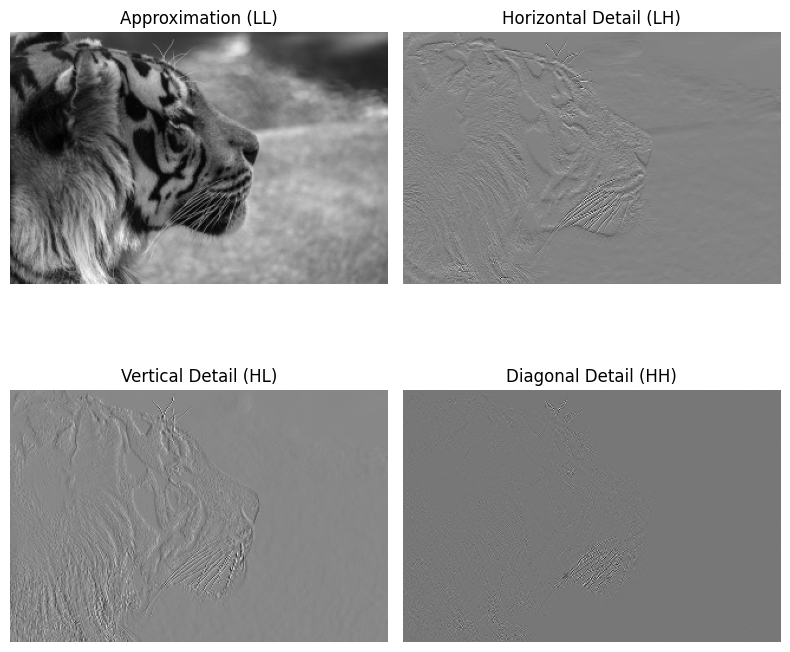

In [ ]:
# Load image
img = cv2.imread('/content/drive/MyDrive/EE608/HW_4_data/tiger.jpg', cv2.IMREAD_GRAYSCALE)

# Perform 2D Wavelet Transform using PyWavelets
coeffs = pywt.dwt2(img, 'haar')

# Split coefficients into sub-bands
cA, (cH, cV, cD) = coeffs

# Plot the sub-bands using plt.subplot()
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()
titles = ['Approximation (LL)', 'Horizontal Detail (LH)', 'Vertical Detail (HL)', 'Diagonal Detail (HH)']
for i, comp in enumerate([cA, cH, cV, cD]):
    ax[i].imshow(comp, cmap=plt.cm.gray)
    ax[i].set_title(titles[i])
    ax[i].set_axis_off()
plt.tight_layout()
plt.show()

# **wavelet denosising**

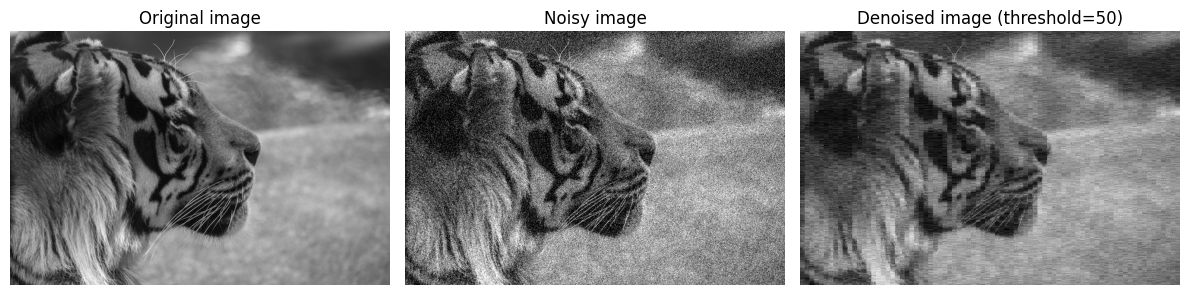

In [26]:
# Load image and add Gaussian noise
img = cv2.imread('/content/drive/MyDrive/EE608/HW_4_data/tiger.jpg',0)
noise = np.random.normal(0, 35, img.shape)
noisy_img = np.clip(img + noise, 0, 255).astype('uint8')

# Choose Haar wavelet filter
wavelet = 'haar'

# Choose level of decomposition
level = 3

# Perform 2D discrete wavelet transform
coeffs = pywt.wavedec(noisy_img, wavelet, level=level)

# Threshold the non-LL bands
threshold = 50
coeffs_thresh = list(coeffs)
for i in range(1, len(coeffs)):
    coeffs_thresh[i] = pywt.threshold(coeffs[i], threshold)

# Perform inverse wavelet transform
denoised_img = pywt.waverec(coeffs_thresh, wavelet)

# Convert the denoised image to uint8 format
denoised_img = np.uint8(denoised_img)

# Display the original, noisy, and denoised images using plt.subplot()
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes.ravel()
ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(noisy_img, cmap=plt.cm.gray)
ax[1].set_title('Noisy image')
ax[2].imshow(denoised_img, cmap=plt.cm.gray)
ax[2].set_title('Denoised image (threshold={})'.format(threshold))
for a in ax:
    a.set_axis_off()
plt.tight_layout()
plt.show()
